In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn import manifold, preprocessing
import warnings

def fix_label(rels):
    rels = [s.replace(' – ',' and ') for s in rels]
    rels = [s.replace('-',' and ') for s in rels]
    rels = [s.replace(' 鈥?',' and ') for s in rels]
    rels = [s.strip() for s in rels]     
    
    rels = [s.replace("Man鈥檚 Wife and Man鈥檚 Mistress",'Man Wife and Man Mistress') for s in rels]
    rels = [s.replace('  and  ',' and ') for s in rels]
    rels = [s.replace('in and laws','in-laws') for s in rels]
    rels = [s.replace('Step and ','Step-')for s in rels]
    rels = [s.replace('Club Member and  Club President','Club Member and Club President')for s in rels]
    rels = [s.replace('Foreman and  Laborer','Foreman and Laborer')for s in rels]
    rels = [s.replace('Godparent and  Godchild','Godparent and Godchild')for s in rels]
    rels = [s.replace('Groom and  Groomsman','Groom and Groomsman')for s in rels]
    rels = [s.replace('Judge  and Lawyer','Judge and Lawyer')for s in rels]
    rels = [s.replace('Step-grandparent and  Step-grandchild','Step-grandparent and Step-grandchild')for s in rels]
    rels = [s.replace('step and ','step-')for s in rels]
    rels = [s.replace('Foster and ','Foster-')for s in rels]
    rels = [s.replace('Sugar and ','Sugar-')for s in rels]
    rels = [s.replace('Co and ','Co-')for s in rels]
    rels = [s.replace('ex and ','ex-')for s in rels]
    rels = [s.replace('pen and ','pen-')for s in rels]
    rels = [s.replace('life and ','life-')for s in rels]
    rels = [s.replace('soul and ','soul-')for s in rels]
    rels = [s.replace('half and ','half-')for s in rels]
    rels = [s.replace('long and distance','long-distance')for s in rels]
    rels = [s.replace('brothers and in and arms','brothers-in-arms')for s in rels]
    
    return rels

def NLP_to_Trans(rels):
    #fix the basic form of label
    rels = fix_label(rels)
    
    #one_to_one
    rels = [s.replace('Supervisor and Graduate student','Mentor and Mentee') for s in rels]
    rels = [s.replace('Between lovers','Between romantic lovers') for s in rels]

    #one_to_two
    rels = [s.replace('Between woman and in-laws','Between a person and their in-laws') for s in rels]
    rels = [s.replace('Between biao cousins','Between cousins') for s in rels]
    rels = [s.replace('Grandparent(father) and Grandchild','Grandparent and Grandchild') for s in rels]
    #'Master-Servant' doesn't need to be changed

    #two_to_two
    rels = [s.replace('Uncle/Aunt and Niece/Nephew1','Aunt and Niece/Nephew') for s in rels]
    rels = [s.replace('Uncle/Aunt and Niece/Nephew','Uncle and Niece/Nephew') for s in rels]

    return rels

# Clean and combine data

In [2]:
warnings.filterwarnings('ignore')
# Grab the qualtrics output
qual_output = '../DataCleanPCA/input_data/Nations/CHN/NLP/Merge_210928.csv'

# Prep responses and key
raw = pd.read_csv(qual_output)
raw_reorg = raw.drop(axis='index',index=[0,1])
raw_reorg['subject'] = list(raw_reorg.index)
raw_reorg = raw_reorg.reset_index(drop=True)
raw_reorg['Duration (in seconds)'] = pd.to_numeric(raw_reorg['Duration (in seconds)'])
key = pd.read_csv('../DataCleanPCA/input_data/Nations/CHN/NLP/qualtrics_question_key.csv')

responses = raw_reorg
responses['subject'] = list(raw_reorg.index)
responses = responses.loc[:, responses.columns.str.startswith('Q')]
responses = responses[responses.columns[1:-7]]

# Get total number of responses
print("Total number of responses from qualtrics - "+str(len(responses)))

#######################################################################################
relationships_trans_258 = pd.read_csv('../DataCleanPCA/input_data/Nations/CHN/NLP/Total_Relation_6_trans.csv', 
                                  header=None).iloc[:,0].tolist()
relationships = NLP_to_Trans(relationships_trans_258)

dimensions = key['dimension'].tolist()[2:-3]
dimensions = [i.replace('Importance for individuals involved','Importance for individuals') for i in dimensions]
dimensions = [i.replace('Moral','Morality') for i in dimensions]
dimensions = [i.replace('Accountable','Trust') for i in dimensions]

dimension_frames = {}
count=2
for dim in dimensions:  # exclude foil and demographics
    filtered_cols = [col for col in raw_reorg if col.startswith('Q'+str(key['block'].iloc[count])+'.2')]
    dimension_frames[dim] = pd.DataFrame(responses[filtered_cols])
    dimension_frames[dim].columns = relationships
    count=count+1
    
# Check total number of responses for each word
num_response = pd.DataFrame(columns=dimensions)
for dim in dimensions:
    num_response[dim] = dimension_frames[dim].count()
    
print("Total number of relationships - " + str(len(dimension_frames[dim].columns)))
print("Total number of dimensions - " + str(len(dimensions)))
print("Smallest number of ratings for a relationship - " + str(min(list(num_response.min()))))
print("Largest number of ratings for a relationship - " + str(max(list(num_response.max()))))

Total number of responses from qualtrics - 6128
Total number of relationships - 258
Total number of dimensions - 35
Smallest number of ratings for a relationship - 15
Largest number of ratings for a relationship - 65


In [3]:
# Check color foils to exclude people
foil_items = [x for x in raw.columns.tolist() if x.startswith('Q2.1')]
foil_items = foil_items + [x for x in raw.columns.tolist() if x.startswith('Q40.1')]
foil_items = raw[foil_items].iloc[0]
foil_items = [s.replace('\xe2\x80\x93', '-') for s in foil_items]
foil_items = [i.split(' - ', 1)[1] for i in foil_items]
filtered_cols = [col for col in raw_reorg if col.startswith(('Q2.1','Q40.1'))]
foils_color_size = pd.DataFrame(responses[filtered_cols])
foils_color_size.columns = foil_items
foils_color_size['SubID']  =raw_reorg['SubID']
foils_color_size = foils_color_size.apply(pd.to_numeric)
foils_color_size_melt = pd.melt(foils_color_size, id_vars='SubID')


# Check for values above means for unexpected foils
outliers_color_size_list = []
for col in foils_color_size.columns[:-1]:
    outliers_color_size_list = outliers_color_size_list + list(foils_color_size[(foils_color_size[col] > 
                   foils_color_size[col].mean()+foils_color_size[col].std()*3.5) |
                   (foils_color_size[col] < 
                    foils_color_size[col].mean()-foils_color_size[col].std()*3.5)].index)
outliers_color_size_list = set(outliers_color_size_list)


# Remove outliers based on assumptions of words
foil_color_size_outliers = foils_color_size
foil_color_size_outliers = foil_color_size_outliers[~foil_color_size_outliers.index.isin(outliers_color_size_list)]
foil_color_size_outliers_melt = pd.melt(foil_color_size_outliers, id_vars='SubID')

# Check foils to see if any subjs responded indiscriminately
foil_relationships = [x for x in raw.iloc[0].tolist() if x.startswith('Q39')]
foil_relationships = [x[6:] for x in foil_relationships]
foil_relationships = [x for x in raw.columns.tolist() if x.startswith('Q39.1')]
foil_relationships = raw[foil_relationships].iloc[0]
foil_relationships = [s.replace('\xe2\x80\x93', '-') for s in foil_relationships]
foil_relationships = [i.split(' - ', 1)[1] for i in foil_relationships]
filtered_cols = [col for col in raw_reorg if col.startswith('Q39.1')]
foils = pd.DataFrame(responses[filtered_cols])
foils.columns = foil_relationships
foils['SubID']  =raw_reorg['SubID']
foils = foils.apply(pd.to_numeric)
foils_melt = pd.melt(foils, id_vars='SubID')


# Check for values above means for unexpected foils
outliers_list = []
for rel in foils.columns[:-1]:
    outliers_list = outliers_list + list(foils[(foils[rel] > 
                   foils[rel].mean()+foils[rel].std()*2) |
                   (foils[rel] < 
                    foils[rel].mean()-foils[rel].std()*2)].index)
outliers_list = set(outliers_list)


# Remove outliers based on assumptions of words
foil_outliers = foils
foil_outliers = foil_outliers[~foil_outliers.index.isin(outliers_list)]
foil_outliers_melt = pd.melt(foil_outliers, id_vars='SubID')

# Remove relationship ratings where subjects indicated that they did not 
# understand the relationships
filtered_cols = [col for col in raw_reorg if col.startswith(('Q3.1'))]
familiarity = pd.DataFrame(raw_reorg[filtered_cols])
familiarity.columns = relationships
familiarity['SubID'] = raw_reorg['SubID']
familiarity = familiarity.apply(pd.to_numeric)
familiarity_melt = pd.melt(familiarity, id_vars='SubID')


# Check for values above means for unexpected foils
familiarity_list = []
for col in familiarity.columns[:-1]:
    familiarity_list = familiarity_list + list(familiarity[(familiarity[col] < 
                    familiarity[col].mean()-familiarity[col].std()*3.5)].index)
familiarity_list = set(familiarity_list)

# Remove outliers from the rest of the data
outliers_all_list = set(list(outliers_list) + list(outliers_color_size_list) + list(familiarity_list))

In [4]:
familiarity_outlier = familiarity[~familiarity.index.isin(outliers_all_list)]
familiarity_nlp = familiarity_outlier.iloc[:,:-1]
familiarity_nlp.to_csv('output_data/familiarity/familiarity_258rels_chn.csv')

In [4]:
dimension_frames_outliers = dimension_frames.copy()
for dim in dimensions:
    dimension_frames_outliers[dim] = dimension_frames[dim][~dimension_frames[dim].index.isin(outliers_all_list)]
    dimension_frames_outliers[dim] = dimension_frames_outliers[dim].apply(pd.to_numeric)
    
# Check total number of responses for each word with outliers excluded
num_response_outliers = pd.DataFrame(index=relationships,columns=dimensions)
for dim in dimensions:
    num_response_outliers[dim] = dimension_frames_outliers[dim].count() 

print("Total number of responses, excluding bad participants - "+str(len(dimension_frames_outliers[dim])))
print("Smallest number of ratings for a relationship - " + str(min(list(num_response_outliers.min()))))
print("Largest number of ratings for a relationship - " + str(max(list(num_response_outliers.max()))))
# Get MTurk codes for outliers
outliers_df = raw_reorg.iloc[list(outliers_all_list)]
outliers_df.to_csv('output_data/outlier_df/NLP_outliers.csv')

Total number of responses, excluding bad participants - 4751
Smallest number of ratings for a relationship - 15
Largest number of ratings for a relationship - 53


In [6]:
result_dict = dimension_frames_outliers
with pd.ExcelWriter('output_data/dict_results/CHN_NLP.xlsx') as writer:
    for dim in result_dict.keys():
        result_dict[dim].to_excel(writer,sheet_name = dim)

# 159rel×33d

## Dict

In [6]:
relationships_trans_258 = pd.read_csv('../DataCleanPCA/input_data/Nations/CHN/NLP/Total_Relation_6_trans.csv', 
                                  header=None).iloc[:,0].tolist()
relationships = NLP_to_Trans(relationships_trans_258)
relationships_159 = pd.read_csv('../DataCleanPCA/input_data/RelDim_labels/159relationships_fix_label.csv',index_col=0)
relationships_159 = relationships_159.iloc[:,0].to_list()

dimensions = key['dimension'].tolist()[2:-3]
dimensions = [i.replace('Importance for individuals involved','Importance for individuals') for i in dimensions]
dimensions = [i.replace('Moral','Morality') for i in dimensions]
dimensions = [i.replace('Accountable','Trust') for i in dimensions]

dimensions_33d = [i for i in dimensions if i not in ['Kinship','Legality']]

dimension_frames_159r_33d = {}
for dim in dimensions_33d:
    dimension_frames_159r_33d[dim] = dimension_frames_outliers[dim].loc[:,relationships_159]
    dimension_frames_159r_33d[dim] = dimension_frames_159r_33d[dim].apply(pd.to_numeric)
    
all_ids = dimension_frames_159r_33d[dim].index.to_list()
left_ids = []
for dim in dimensions_33d:
    temp_df = dimension_frames_159r_33d[dim].copy()
    temp_df.dropna(how='all',inplace=True)
    left_id = temp_df.index.to_list()
    [left_ids.append(i) for i in left_id]
left_ids = list(set(left_ids))

dimension_frames_159r_33d_outliers = dimension_frames_159r_33d.copy()
for dim in dimensions_33d:
    dimension_frames_159r_33d_outliers[dim] = dimension_frames_159r_33d_outliers[dim].loc[left_ids,:]
    dimension_frames_159r_33d_outliers[dim] = dimension_frames_159r_33d_outliers[dim].apply(pd.to_numeric)

In [7]:
# Check total number of responses for each word
num_response = pd.DataFrame(columns=dimensions_33d)
for dim in dimensions_33d:
    num_response[dim] = dimension_frames_159r_33d_outliers[dim].count() 
print("Total number of responses, including all participants - "+str(len(dimension_frames_159r_33d_outliers[dim])))
print("Smallest number of ratings for a relationship - " + str(min(list(num_response.min()))))
print("Largest number of ratings for a relationship - " + str(max(list(num_response.max()))))

Total number of responses, including all participants - 4722
Smallest number of ratings for a relationship - 15
Largest number of ratings for a relationship - 46


## Dim_rel(scaled)

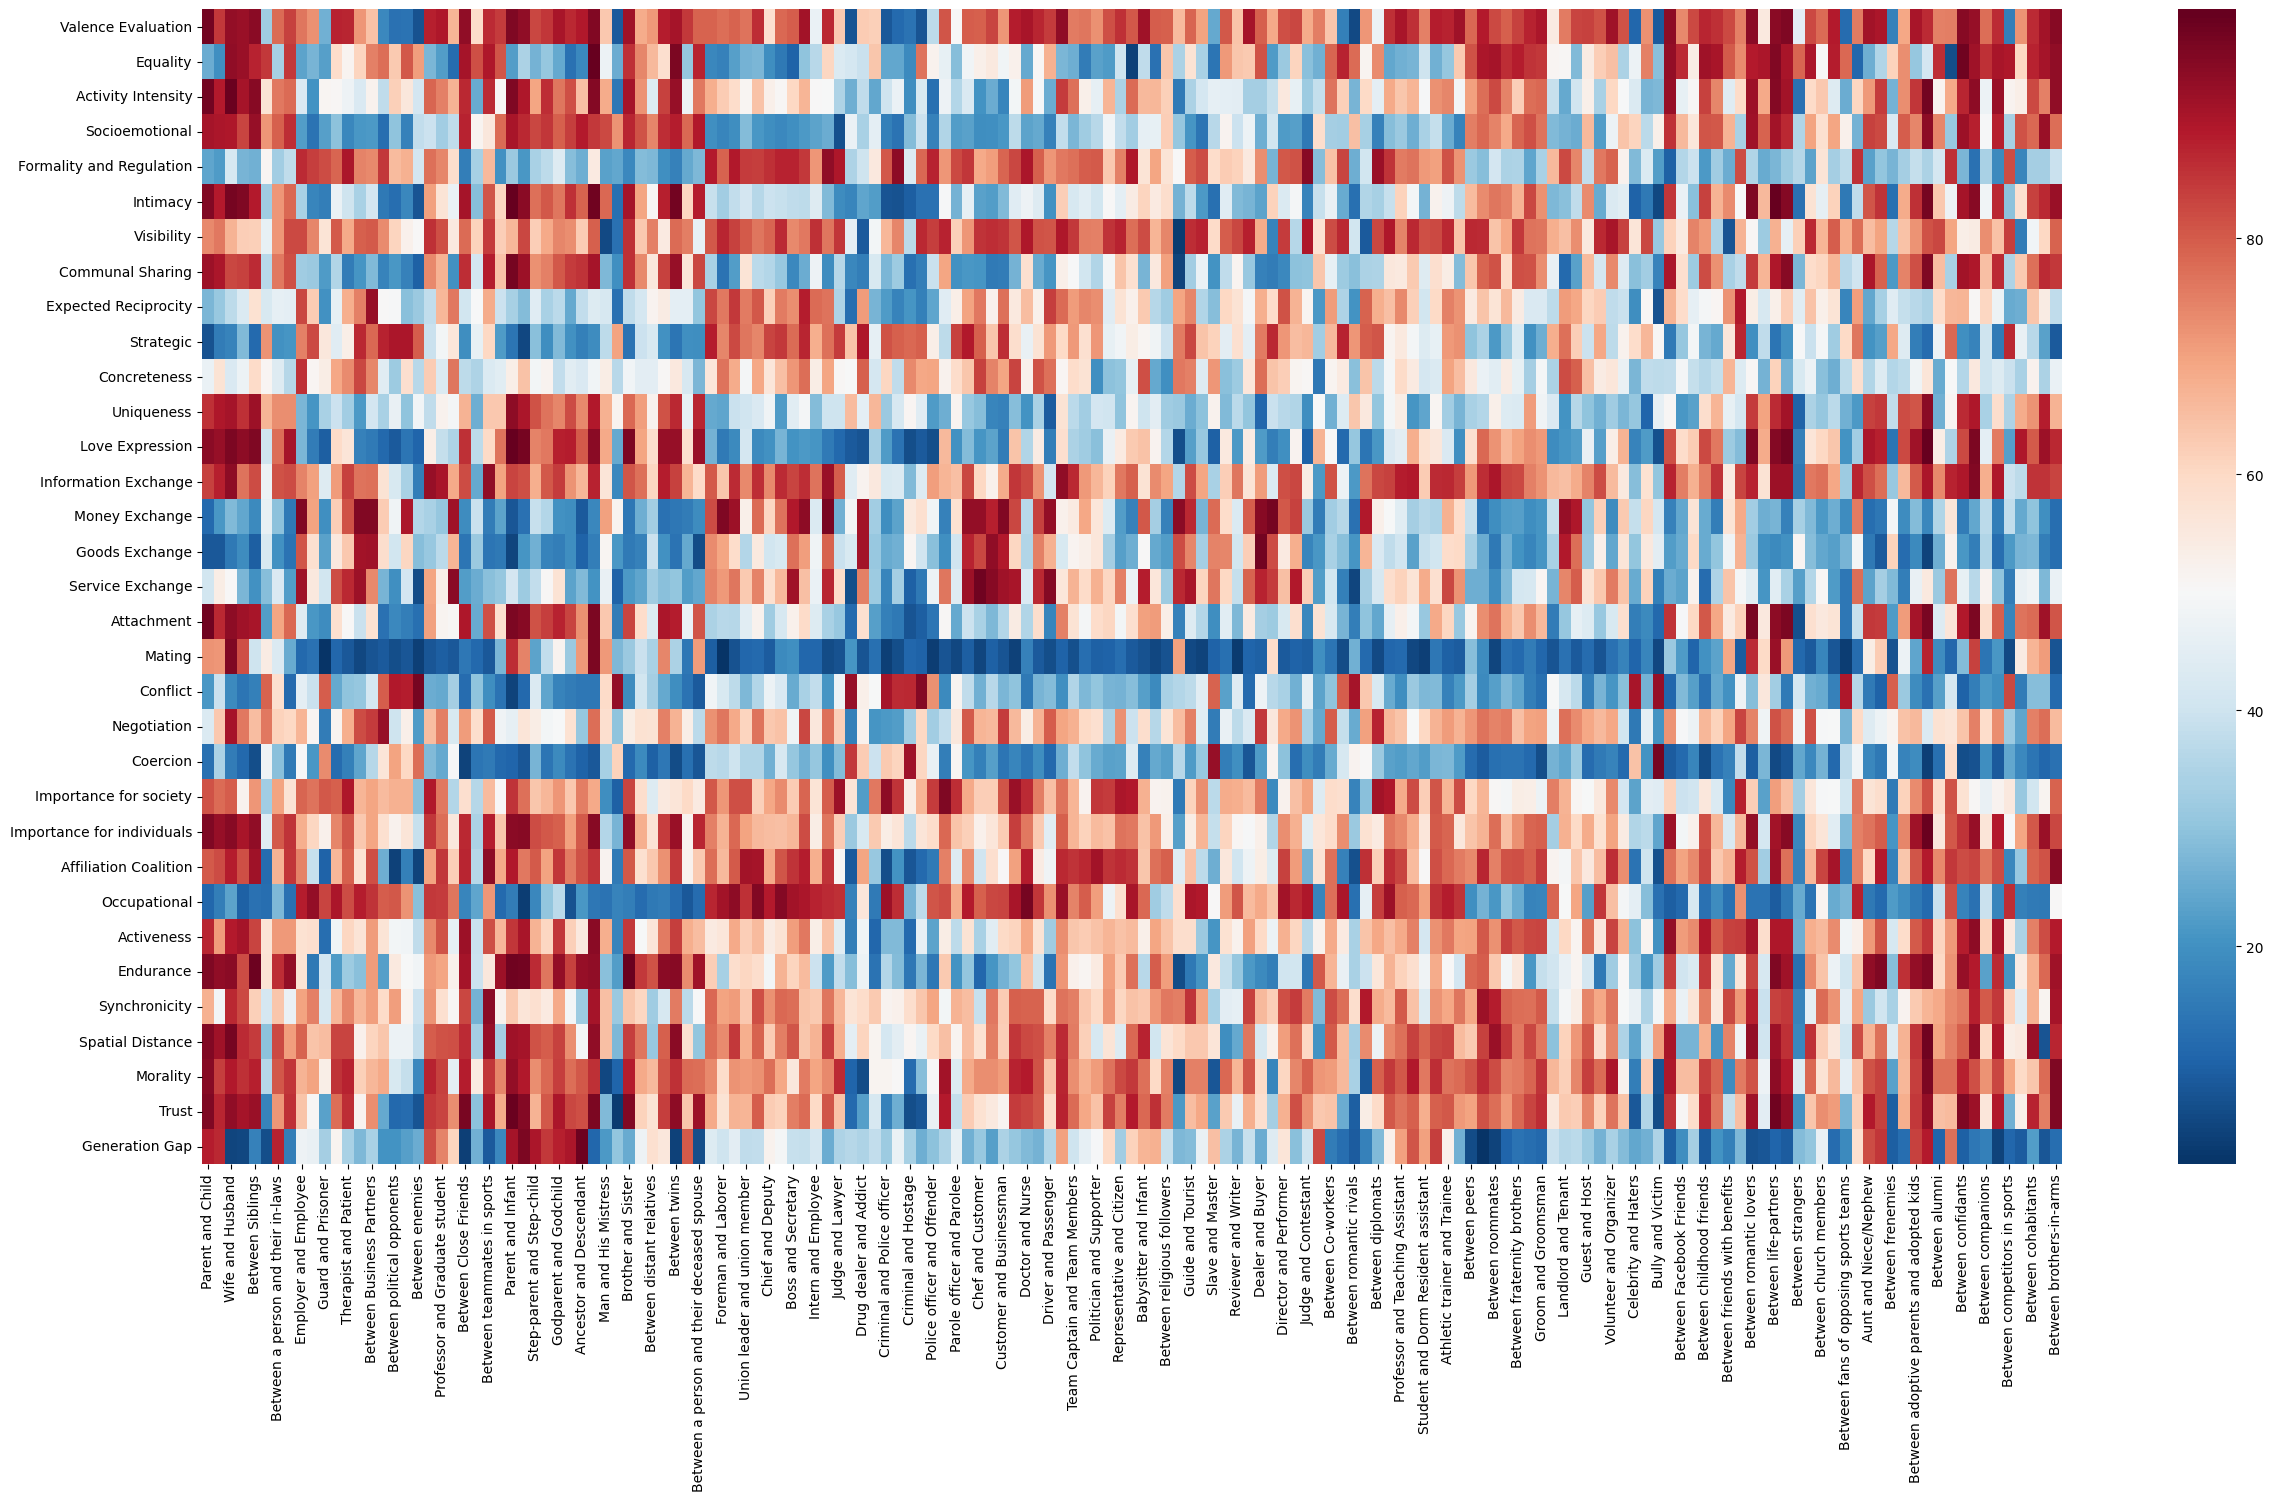

In [8]:
Clean_dict = dimension_frames_159r_33d_outliers
dim_rel = pd.DataFrame(columns=relationships_159)        
count=0
for dim in Clean_dict.keys():
    dim_rel.loc[count] = Clean_dict[dim].mean().tolist()
    count = count + 1
dim_rel.index = Clean_dict.keys()
dim_rel.to_csv('output_data/cleaning_results/CHN/CHN_dim_rel_NLP_159r_33d.csv')

plt.figure(figsize=(30,15))
heatmap = sns.heatmap(dim_rel, center=50,cmap="RdBu_r")

dim_rel_scaled = preprocessing.scale(dim_rel.transpose())
dim_rel_scaled_df = pd.DataFrame(dim_rel_scaled, index=dim_rel.columns,
                                 columns=dim_rel.index)
dim_rel_scaled_df.to_csv('output_data/cleaning_results/CHN/CHN_dim_rel_scaled_NLP_159r_33d.csv')

# 159rel×35d

## Dict

In [10]:
dimensions_35d = dimensions

In [11]:
dimension_frames_159r_35d = {}
for dim in dimensions_35d:
    dimension_frames_159r_35d[dim] = dimension_frames_outliers[dim].loc[:,relationships_159]
    dimension_frames_159r_35d[dim] = dimension_frames_159r_35d[dim].apply(pd.to_numeric)
    
all_ids = dimension_frames_159r_35d[dim].index.to_list()
left_ids = []
for dim in dimensions_35d:
    temp_df = dimension_frames_159r_35d[dim].copy()
    temp_df.dropna(how='all',inplace=True)
    left_id = temp_df.index.to_list()
    [left_ids.append(i) for i in left_id]
left_ids = list(set(left_ids))

dimension_frames_159r_35d_outliers = dimension_frames_159r_35d.copy()
for dim in dimensions_35d:
    dimension_frames_159r_35d_outliers[dim] = dimension_frames_159r_35d_outliers[dim].loc[left_ids,:]
    dimension_frames_159r_35d_outliers[dim] = dimension_frames_159r_35d_outliers[dim].apply(pd.to_numeric)

In [12]:
# Check total number of responses for each word
num_response = pd.DataFrame(columns=dimensions_33d)
for dim in dimensions_35d:
    num_response[dim] = dimension_frames_159r_35d_outliers[dim].count() 
print("Total number of responses, including all participants - "+str(len(dimension_frames_159r_35d_outliers[dim])))
print("Smallest number of ratings for a relationship - " + str(min(list(num_response.min()))))
print("Largest number of ratings for a relationship - " + str(max(list(num_response.max()))))

Total number of responses, including all participants - 4722
Smallest number of ratings for a relationship - 15
Largest number of ratings for a relationship - 46


## Dim_rel(scaled)

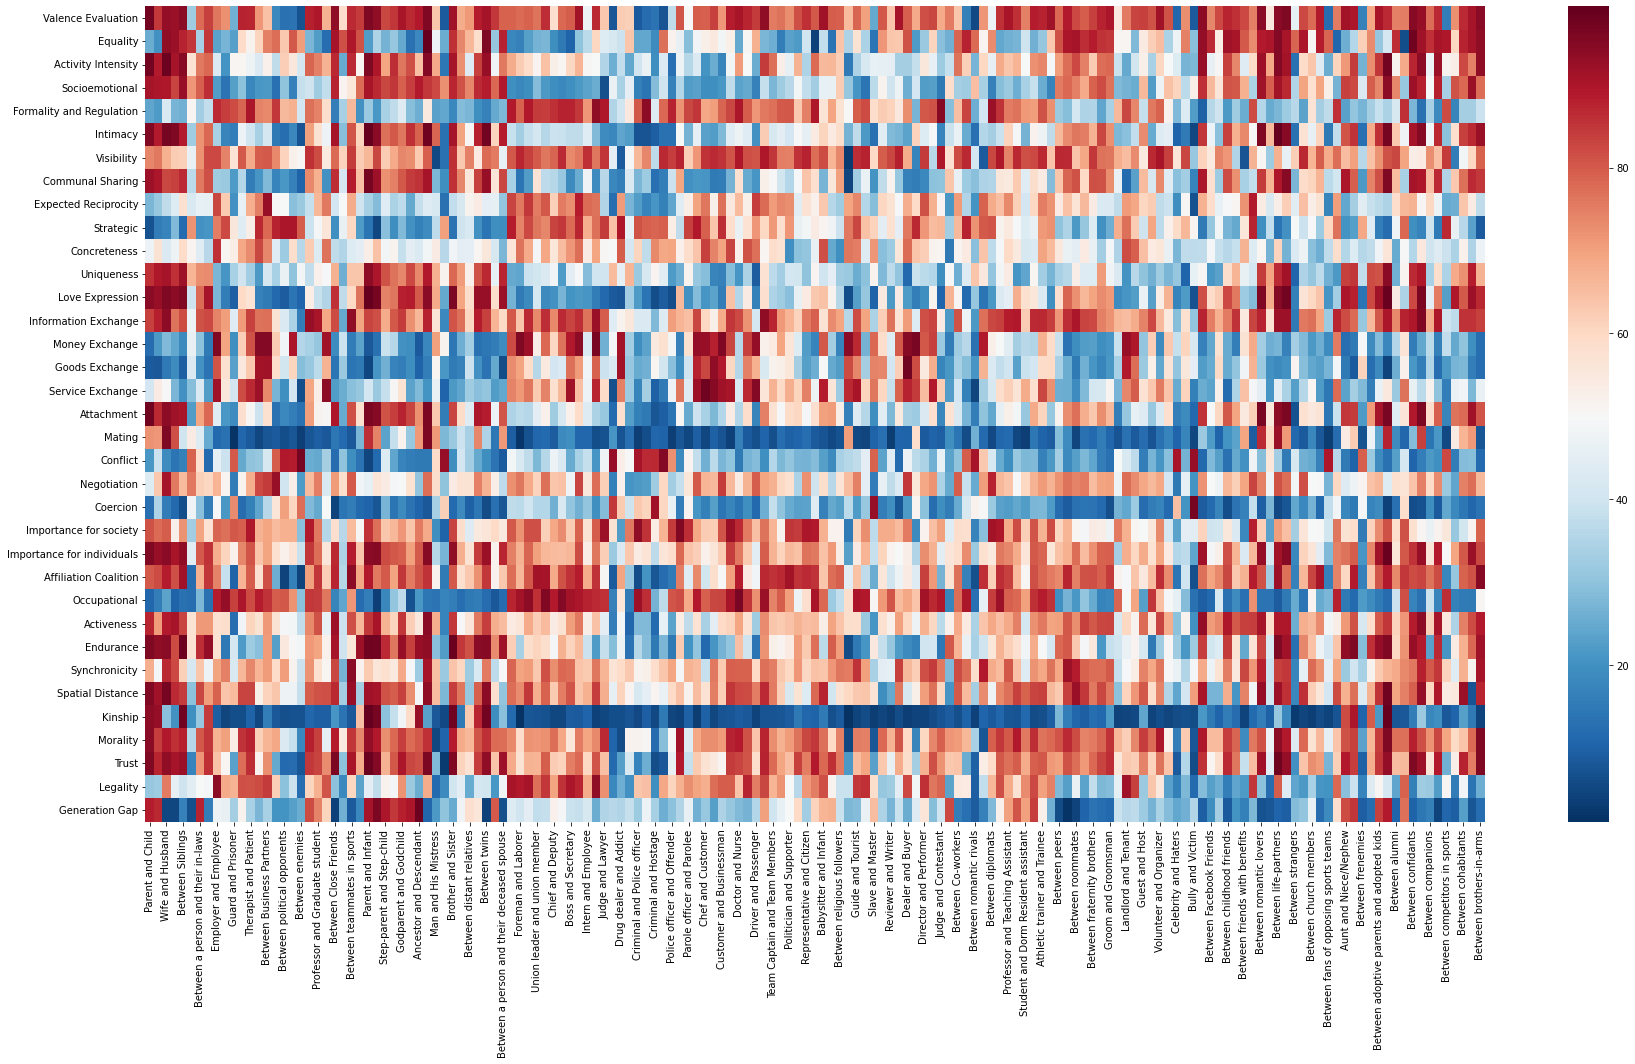

In [13]:
Clean_dict = dimension_frames_159r_35d_outliers
dim_rel = pd.DataFrame(columns=relationships_159)        
count=0
for dim in Clean_dict.keys():
    dim_rel.loc[count] = Clean_dict[dim].mean().tolist()
    count = count + 1
dim_rel.index = Clean_dict.keys()
dim_rel.to_csv('output_data/cleaning_results/CHN/CHN_dim_rel_NLP_159r_35d.csv')

plt.figure(figsize=(30,15))
heatmap = sns.heatmap(dim_rel, center=50,cmap="RdBu_r")

dim_rel_scaled = preprocessing.scale(dim_rel.transpose())
dim_rel_scaled_df = pd.DataFrame(dim_rel_scaled, index=dim_rel.columns,
                                 columns=dim_rel.index)
dim_rel_scaled_df.to_csv('output_data/cleaning_results/CHN/CHN_dim_rel_scaled_NLP_159r_35d.csv')

# 258rel×33d

## Dict

In [9]:
relationships_trans_258 = pd.read_csv('../DataCleanPCA/input_data/Nations/CHN/NLP/Total_Relation_6_trans.csv', 
                                  header=None).iloc[:,0].tolist()
relationships_258 = NLP_to_Trans(relationships_trans_258)

dimension_frames_258r_33d = {}
for dim in dimensions_33d:
    dimension_frames_258r_33d[dim] = dimension_frames_outliers[dim].apply(pd.to_numeric)
    
all_ids = dimension_frames_258r_33d[dim].index.to_list()
left_ids = []
for dim in dimensions_33d:
    temp_df = dimension_frames_258r_33d[dim].copy()
    temp_df.dropna(how='all',inplace=True)
    left_id = temp_df.index.to_list()
    [left_ids.append(i) for i in left_id]
left_ids = list(set(left_ids))

dimension_frames_258r_33d_outliers = dimension_frames_258r_33d.copy()
for dim in dimensions_33d:
    dimension_frames_258r_33d_outliers[dim] = dimension_frames_258r_33d_outliers[dim].loc[left_ids,:]
    dimension_frames_258r_33d_outliers[dim] = dimension_frames_258r_33d_outliers[dim].apply(pd.to_numeric)

In [10]:
# Check total number of responses for each word
num_response = pd.DataFrame(columns=dimensions_33d)
for dim in dimensions_33d:
    num_response[dim] = dimension_frames_258r_33d_outliers[dim].count() 
print("Total number of responses, including all participants - "+str(len(dimension_frames_258r_33d_outliers[dim])))
print("Smallest number of ratings for a relationship - " + str(min(list(num_response.min()))))
print("Largest number of ratings for a relationship - " + str(max(list(num_response.max()))))

Total number of responses, including all participants - 4751
Smallest number of ratings for a relationship - 15
Largest number of ratings for a relationship - 53


## Dim_rel(scaled)

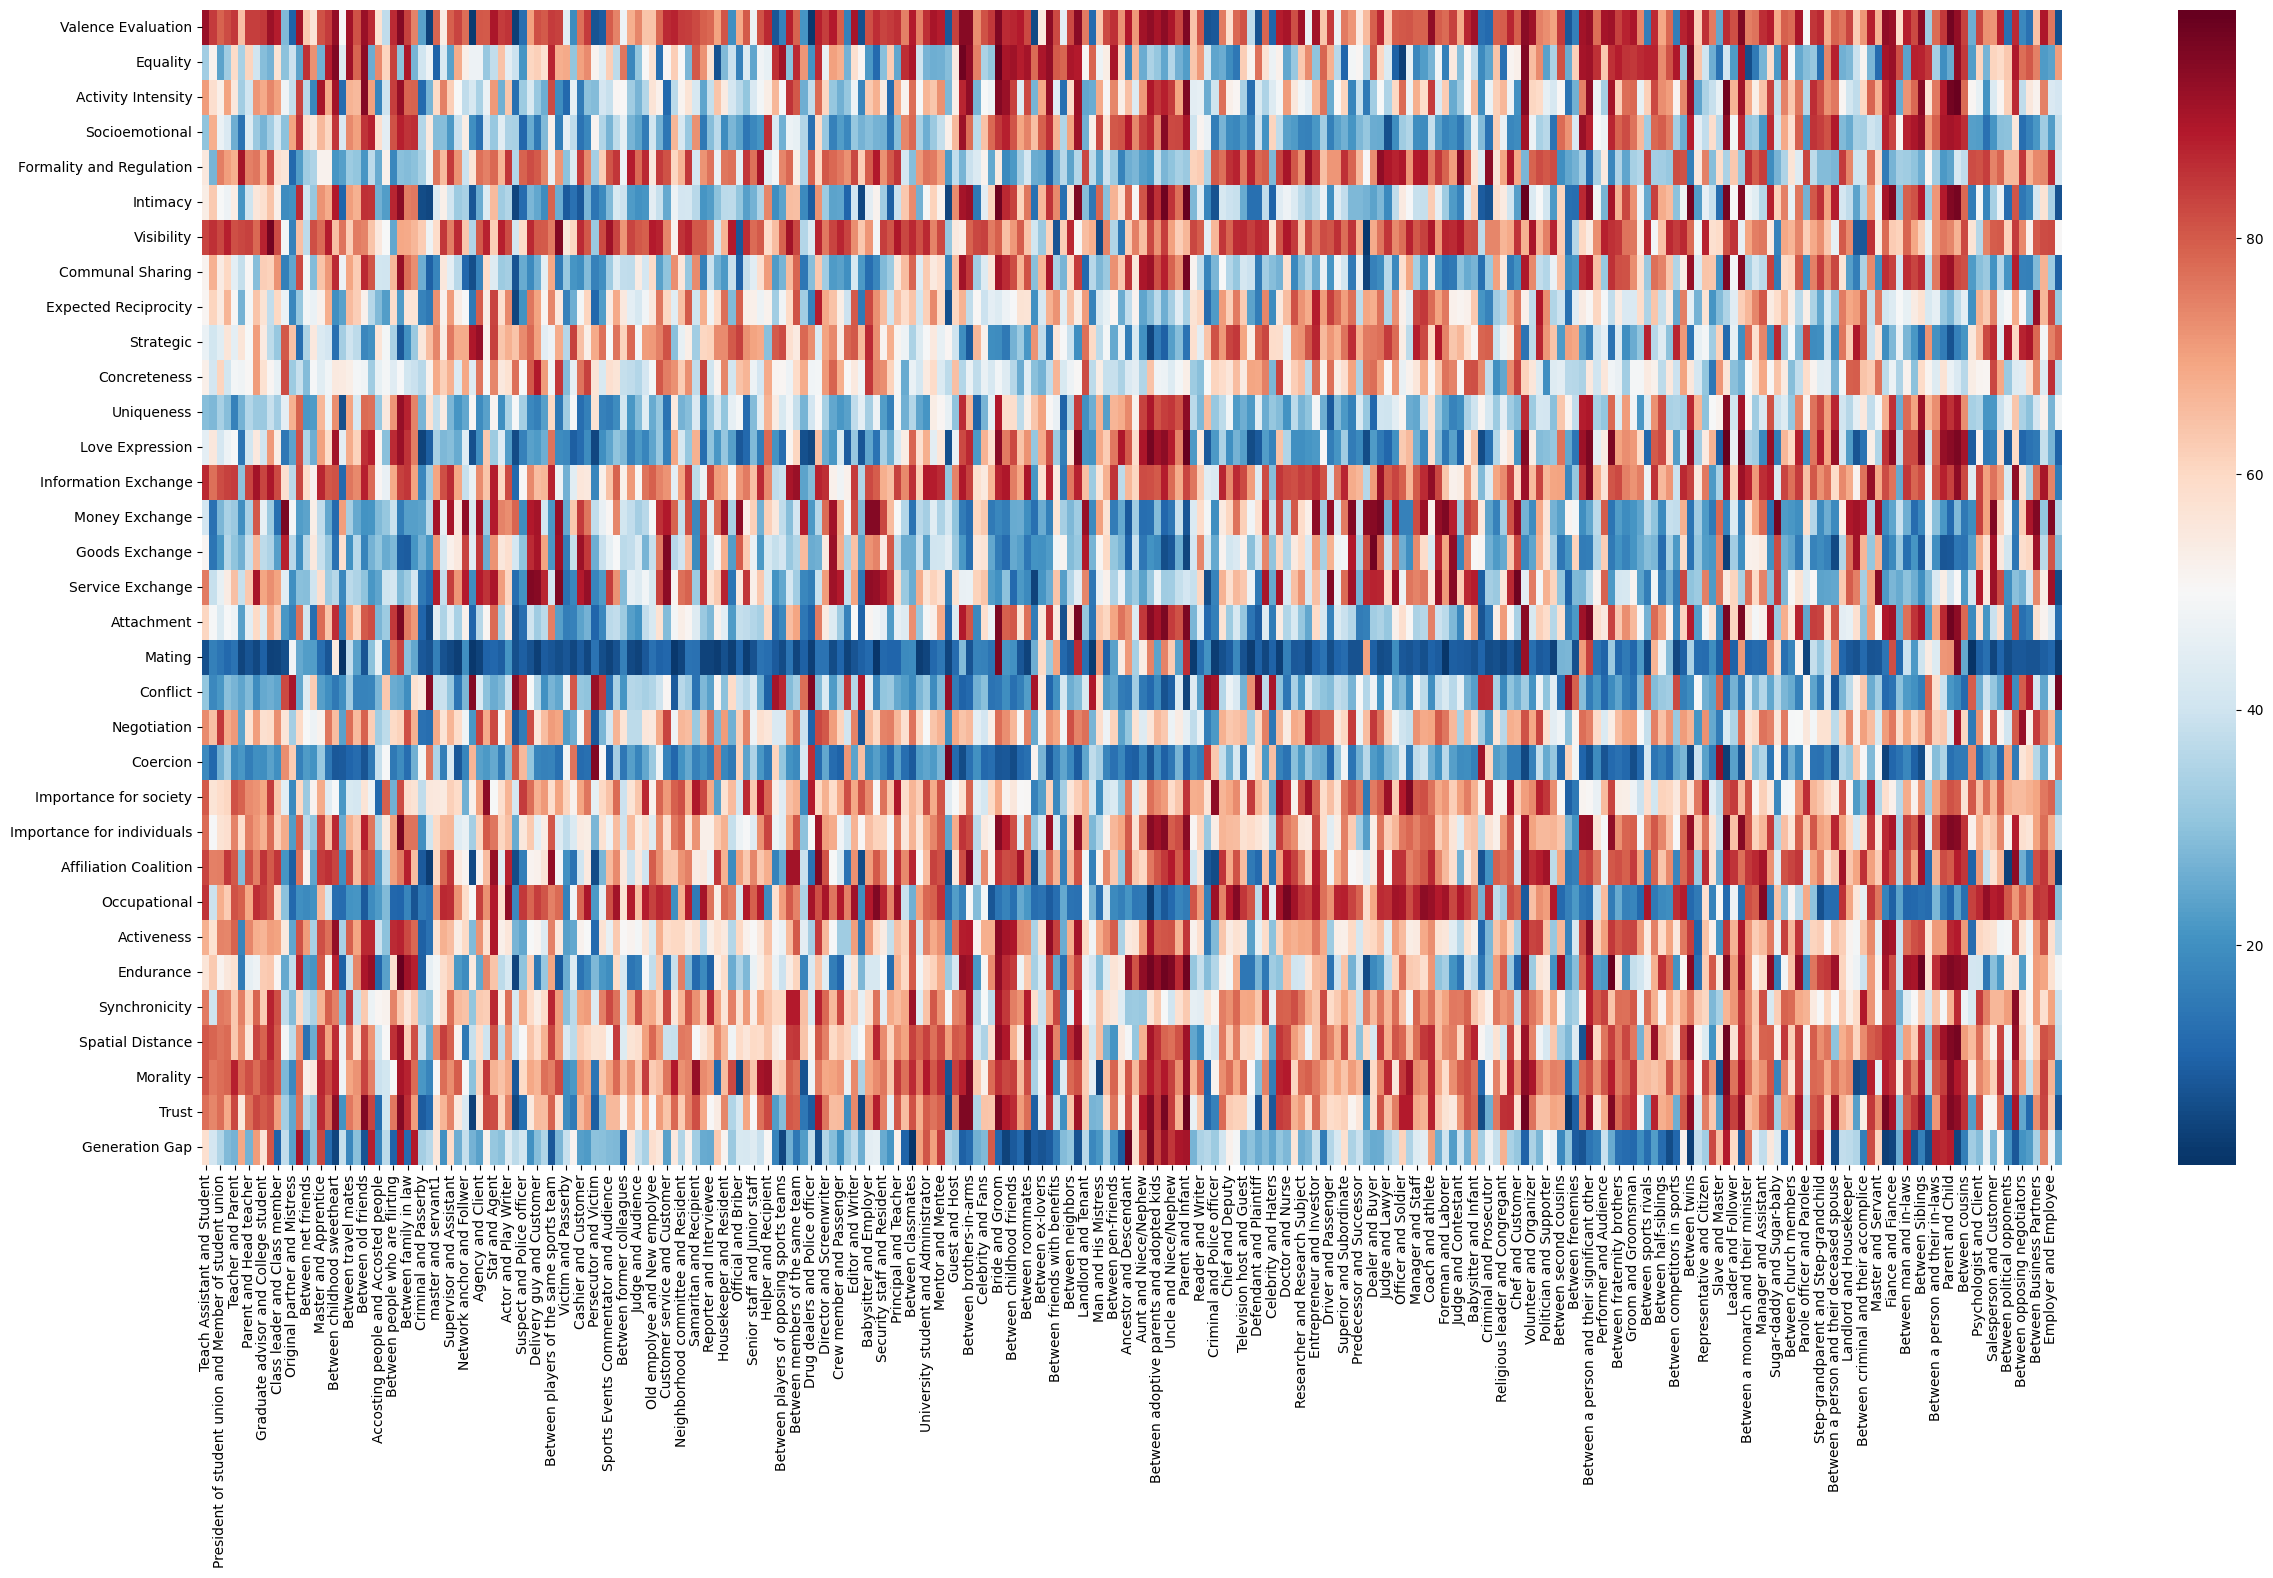

In [11]:
Clean_dict = dimension_frames_258r_33d_outliers
dim_rel = pd.DataFrame(columns=relationships)    
                 
count=0
for dim in Clean_dict.keys():
    dim_rel.loc[count] = Clean_dict[dim].mean().tolist()
    count = count + 1
dim_rel.index = Clean_dict.keys()
dim_rel.to_csv('output_data/cleaning_results/CHN/CHN_dim_rel_NLP_258r_33d.csv')

plt.figure(figsize=(30,15))
heatmap = sns.heatmap(dim_rel, center=50,cmap="RdBu_r")

dim_rel_scaled = preprocessing.scale(dim_rel.transpose())
dim_rel_scaled_df = pd.DataFrame(dim_rel_scaled, index=dim_rel.columns,
                                 columns=dim_rel.index)
dim_rel_scaled_df.to_csv('output_data/cleaning_results/CHN/CHN_dim_rel_scaled_NLP_258r_33d.csv')

# 258rel×30d

## Dict

In [12]:
relationships_trans_258 = pd.read_csv('../DataCleanPCA/input_data/Nations/CHN/NLP/Total_Relation_6_trans.csv', 
                                  header=None).iloc[:,0].tolist()
relationships_258 = NLP_to_Trans(relationships_trans_258)
dimensions_30d = dimensions_33d[0:30]

dimension_frames_258r_30d = {}
for dim in dimensions_30d:
    dimension_frames_258r_30d[dim] = dimension_frames_outliers[dim].apply(pd.to_numeric)
    
all_ids = dimension_frames_258r_30d[dim].index.to_list()
left_ids = []
for dim in dimensions_30d:
    temp_df = dimension_frames_258r_30d[dim].copy()
    temp_df.dropna(how='all',inplace=True)
    left_id = temp_df.index.to_list()
    [left_ids.append(i) for i in left_id]
left_ids = list(set(left_ids))

dimension_frames_258r_30d_outliers = dimension_frames_258r_30d.copy()
for dim in dimensions_30d:
    dimension_frames_258r_30d_outliers[dim] = dimension_frames_258r_30d_outliers[dim].loc[left_ids,:]
    dimension_frames_258r_30d_outliers[dim] = dimension_frames_258r_30d_outliers[dim].apply(pd.to_numeric)

In [13]:
# Check total number of responses for each word
num_response = pd.DataFrame(columns=dimensions_30d)
for dim in dimensions_30d:
    num_response[dim] = dimension_frames_258r_30d_outliers[dim].count() 
print("Total number of responses, including all participants - "+str(len(dimension_frames_258r_30d_outliers[dim])))
print("Smallest number of ratings for a relationship - " + str(min(list(num_response.min()))))
print("Largest number of ratings for a relationship - " + str(max(list(num_response.max()))))

Total number of responses, including all participants - 4508
Smallest number of ratings for a relationship - 15
Largest number of ratings for a relationship - 53


## Dim_rel(scaled)

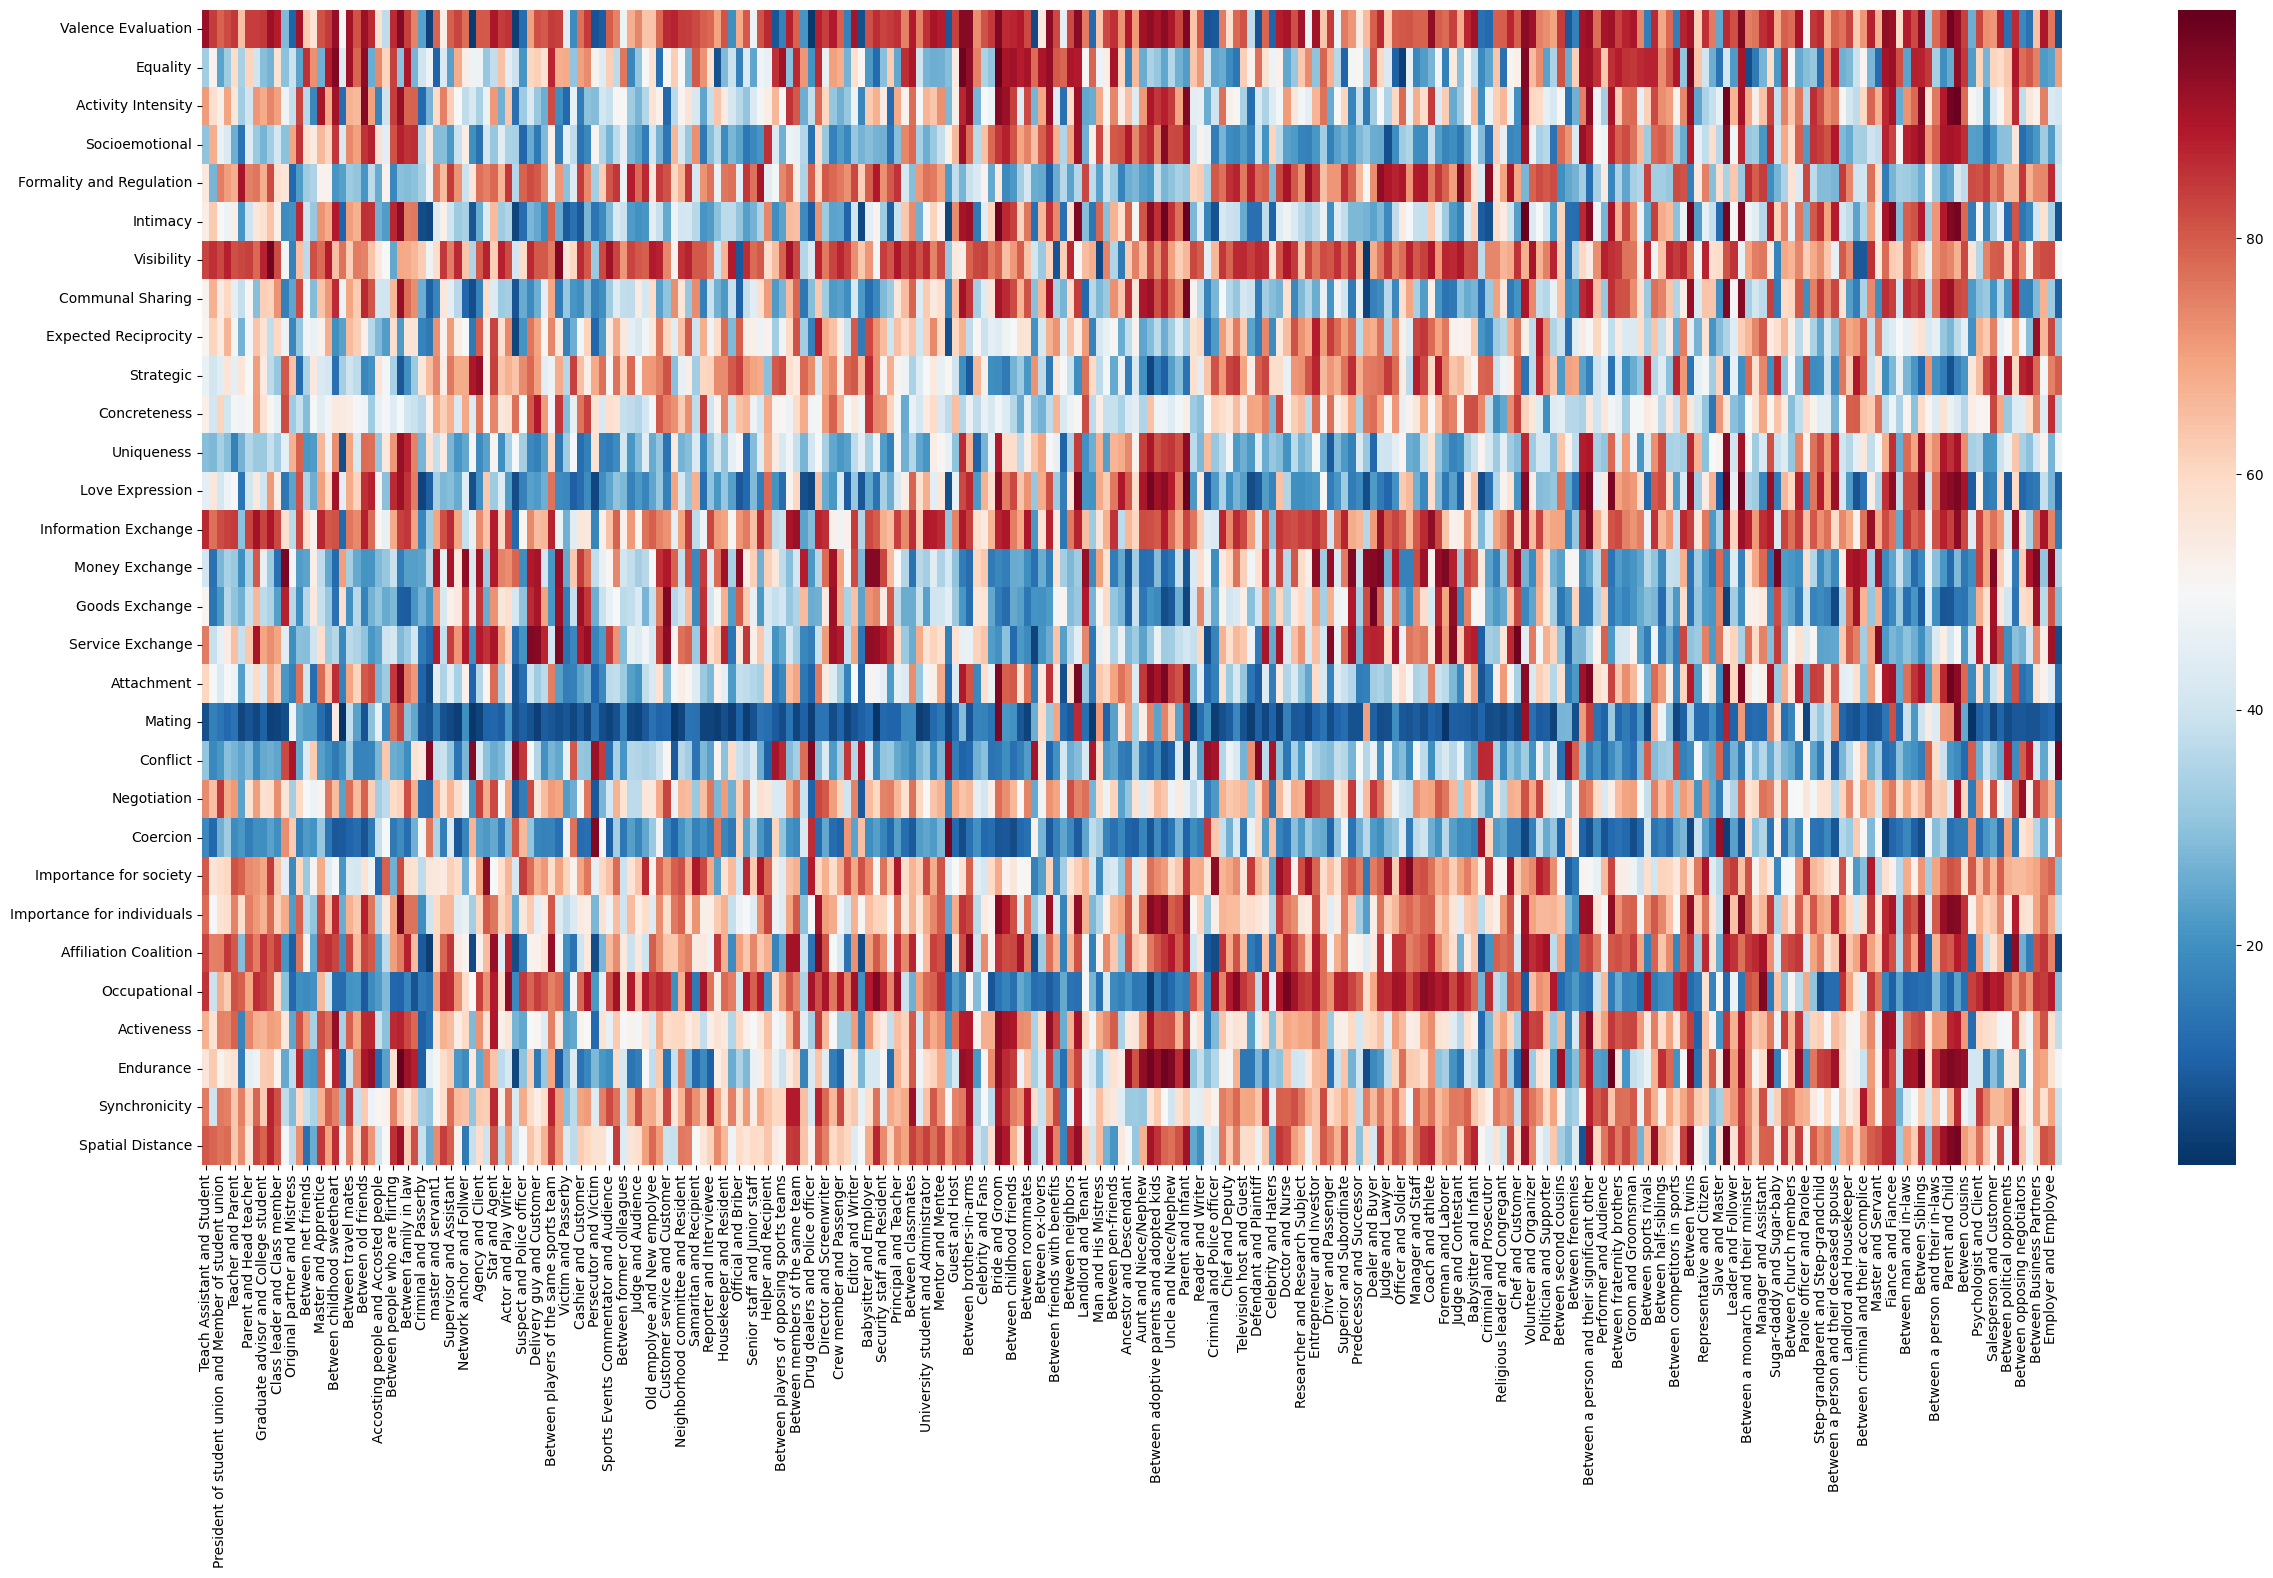

In [14]:
Clean_dict = dimension_frames_258r_30d_outliers
dim_rel = pd.DataFrame(columns=relationships)    
                 
count=0
for dim in Clean_dict.keys():
    dim_rel.loc[count] = Clean_dict[dim].mean().tolist()
    count = count + 1
dim_rel.index = Clean_dict.keys()
dim_rel.to_csv('output_data/cleaning_results/CHN/CHN_dim_rel_NLP_258r_30d.csv')

plt.figure(figsize=(30,15))
heatmap = sns.heatmap(dim_rel, center=50,cmap="RdBu_r")

dim_rel_scaled = preprocessing.scale(dim_rel.transpose())
dim_rel_scaled_df = pd.DataFrame(dim_rel_scaled, index=dim_rel.columns,
                                 columns=dim_rel.index)
dim_rel_scaled_df.to_csv('output_data/cleaning_results/CHN/CHN_dim_rel_scaled_NLP_258r_30d.csv')

# PCA

In [3]:
library(FactoMineR)
library(factoextra)#fviz_eig
library(psych)

library(ggplot2)
library(corrplot)
library(RColorBrewer)

library(tidyverse)
library(reshape)#melt
library(nFactors)#optimal number of components

In [4]:
plotnScree <-
function (nScree,
          elbow = 3,
          legend = TRUE,
          ylab   = "Eigenvalues",
          xlab   = "Components",
          main   = "Non Graphical Solutions to Scree Test")
          {
   if (!inherits(nScree, "nScree"))  stop("Method is only for nScree objects")
   #if (!exists("legend", mode="logical") ) legend <- TRUE                                   # To develop
   #if (!exists("ylab"))                    ylab <- "Eigenvalues"                            # To develop
   #if (!exists("xlab"))                    xlab <- "Components"                             # To develop
   #if (!exists("main"))                    main <- "Non Graphical Solutions to Scree Test"  # To develop
   if (nScree$Model == "components") nkaiser = "Eigenvalues (>mean  = " else nkaiser = "Eigenvalues (>0 = "
   if (nScree$Model == "factors")  xlab   = "Factors"
   # panel
   par(col   = 1, pch = 1, cex=4)     # Color and symbol for usual scree
   par(mfrow = c(1,1),lwd=2, cex=4)
   eig        <- nScree$Analysis$Eigenvalues
   k          <- 1:length(eig)
   #plotuScree(x=eig, ...)                                                                   # To develop
   plotuScree(x=eig, main=main, xlab=xlab, ylab=ylab,col=2)
   nk         <- length(eig)
   noc        <- nScree$Components$noc
   vp.p       <- lm(eig[c(noc+1,nk)] ~ k[c(noc+1,nk)])
   x          <- sum(c(1,1) * coef(vp.p))
   y          <- sum(c(1,nk)* coef(vp.p))
   par(col = 10, cex=1.8)            # Color for optimal coordinates
   lines(k[c(1,nk)],c(x,y),lwd=1.8)
   par(col = 11,pch=2, cex=1.5)            # Color and symbol for parallel analysis
   lines(1:nk, nScree$Analysis$Par.Analysis, type = "b",lwd=1.8)
   if (legend == TRUE) {
     leg.txt  <- c(paste("Parallel Analysis (n = ",nScree$Components$nparallel,")"),
                 c(paste("Kaiser-Guttman rule (n = ",nScree$Components$nkaiser,")")),
                 c(paste("Cattell’s scree test (n = ",elbow,")")),
                 c(paste("Optimal Coordinates (n = ",nScree$Components$noc,")")) )
     legend("topright",
            legend   = leg.txt,
            pch      = c('△','_','○','_'),
            text.col = c(3,4,1,2), 
            col = c(3,4,1,2),
            cex = 1)
     }
   naf        <-   nScree$Components$naf
   text(x = noc ,    y = eig[noc],     label = " (OC)", cex = 1.2, adj = c(0,0), col = 2)
#    text(x = naf + 1, y = eig[naf + 1], label = " (AF)", cex = .70, adj = c(0,0), col = 4)
   }

## 159rel×33d

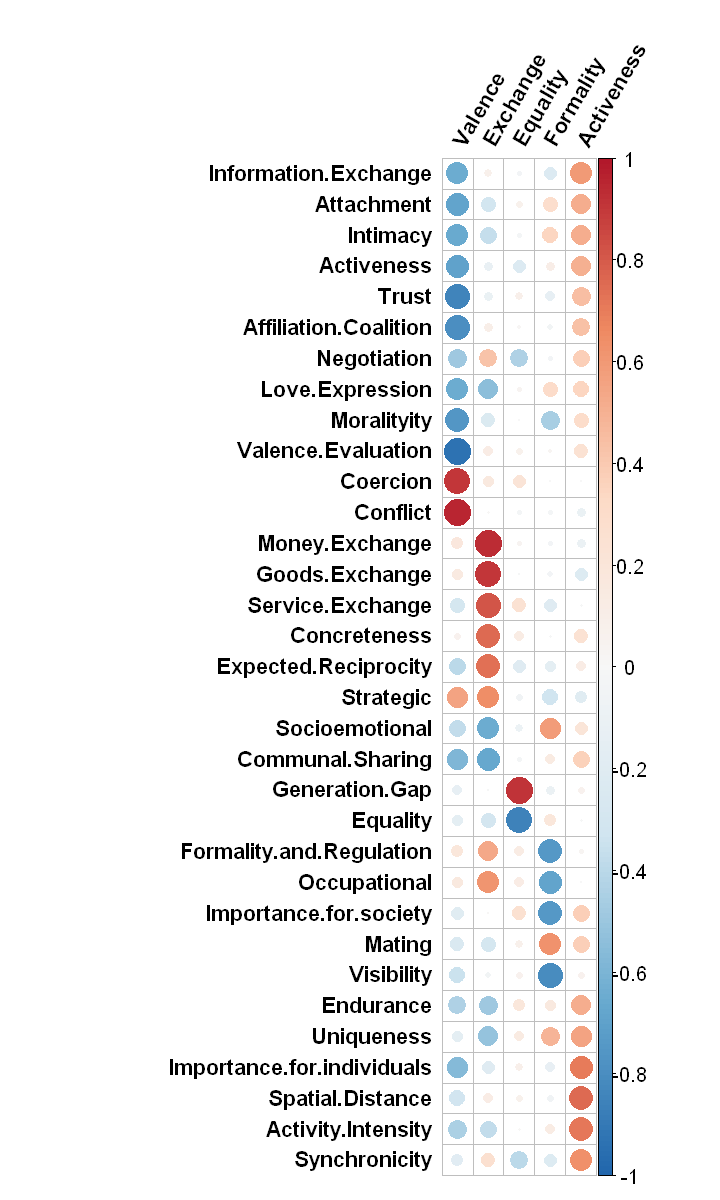

In [5]:
dim_rel_scaled = read.csv('output_data/cleaning_results/CHN/CHN_dim_rel_scaled_NLP_159r_33d.csv',
                          row.names=1,encoding='UTF-8')

dim_rel.pca = prcomp(dim_rel_scaled)
ncomp = 5

loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

loadings_var = varimax(loadings_none)$loadings
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

dims = rownames(loadings_var)
dims = gsub('Moral','Morality',dims)
dims = gsub('Accountable','Trust',dims)
rownames(loadings_var) = dims

write.csv(loadings_var,'output_data/pca_results/CHN/CHN_NLP_159rel_33d_loadings_var.csv')
write.csv(scores_var,'output_data/pca_results/CHN/CHN_NLP_159rel_33d_scores_var.csv')

loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])
colnames(loadings_var_reorder) = c('Valence','Exchange','Equality','Formality','Activeness')

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:5)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(Activeness))
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(Exchange))
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(Formality)
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(desc(Valence))
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(desc(Equality))

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5)
loadings_var_reorder = loadings_var_reorder[1:5]

options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1,1),cl.ratio = 0.4,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))

## 258rel×33d

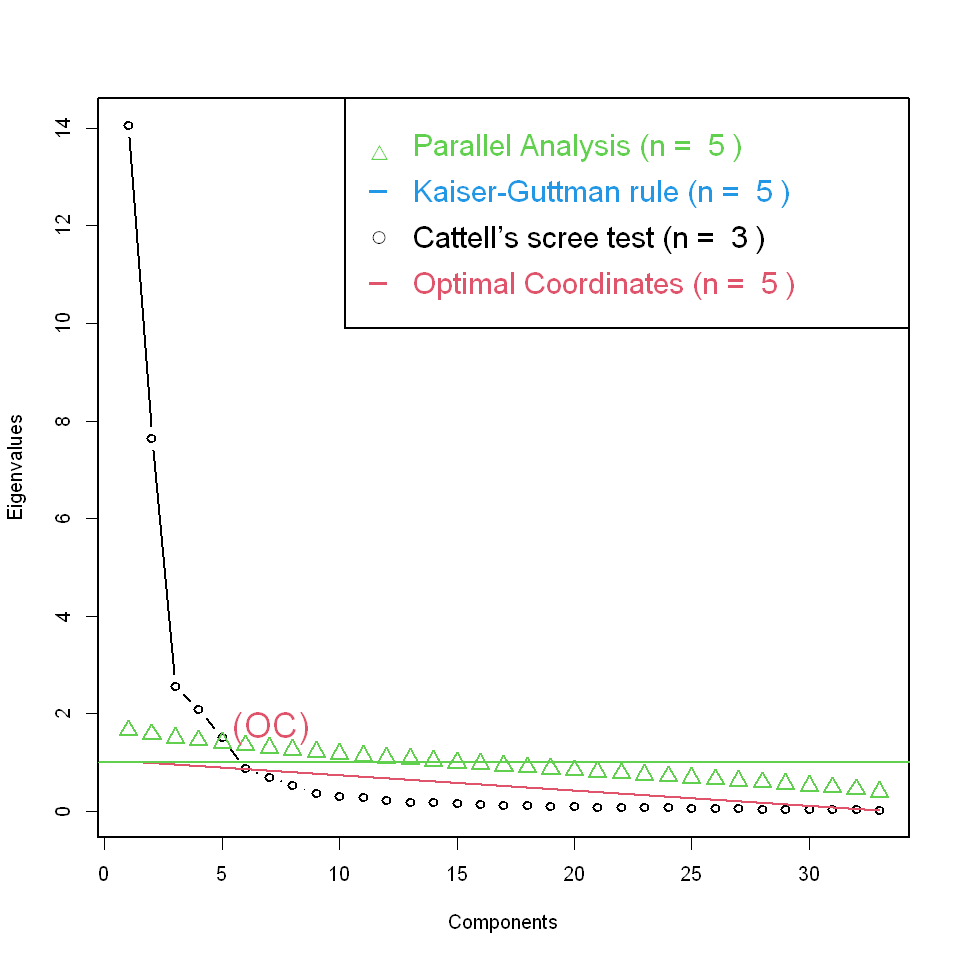

In [6]:
# import relationship dimension ratings scaled from the Data cleaning's output
dim_rel_scaled = read.csv('output_data/cleaning_results/CHN/CHN_dim_rel_scaled_NLP_258r_33d.csv', 
                          row.names=1,encoding='UTF-8',check.names=FALSE)

options(repr.plot.width=8, repr.plot.height=8)
# Parallel analysis, Optimal Coordinates, and  Cattell's Scree Test
ev <- eigen(cor(dim_rel_scaled)) # get eigenvalues
ap <- parallel(subject=nrow(dim_rel_scaled),var=ncol(dim_rel_scaled),model="components",rep=5000,cent=.05) 
nS <- nScree(x=ev$values, aparallel=ap$eigen$qevpea) # "qevpea" indicate 95 centile given cent=.05

plotnScree(nS,elbow = 3, legend=TRUE, main = NULL)
abline(h = 1, col=3, lty=1,lwd =1.8) # Kaiser-Guttman Rule

In [8]:
png("../output_graph/USA_CHN/optimalnum_NLP_258r33d.png", bg="transparent",
    family = 'sans',units='in',width=8,height=8,res=300)
plotnScree(nS,elbow = 3, legend=TRUE, main = NULL)
abline(h = 1, col=3, lty=1,lwd =1.8) # Kaiser-Guttman Rule
dev.off()

png 
  2


Loadings:
                           [,1]   [,2]   [,3]   [,4]   [,5]  
Valence.Evaluation         -0.507  0.188                0.808
Equality                          -0.257  0.198 -0.849  0.212
Activity.Intensity         -0.868 -0.297  0.135         0.172
Socioemotional             -0.357 -0.588  0.613         0.303
Formality.and.Regulation           0.502 -0.790  0.102 -0.137
Intimacy                   -0.742 -0.311  0.326         0.453
Visibility                 -0.103        -0.767         0.414
Communal.Sharing           -0.555 -0.619  0.143         0.473
Expected.Reciprocity       -0.341  0.702 -0.173 -0.208  0.305
Strategic                   0.333  0.609 -0.342        -0.524
Concreteness                       0.780         0.105       
Uniqueness                 -0.587 -0.488  0.496  0.138       
Love.Expression            -0.555 -0.478  0.327         0.527
Information.Exchange       -0.788  0.109 -0.223         0.398
Money.Exchange              0.171  0.924               -0.1

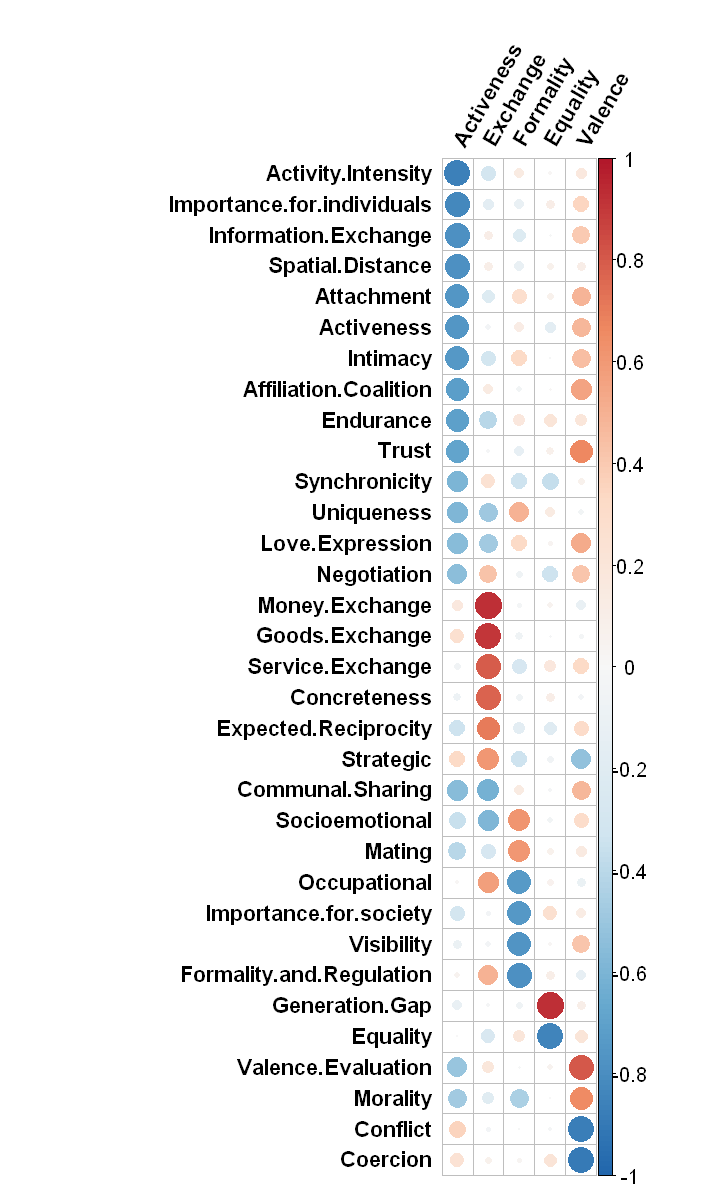

In [11]:
dim_rel_scaled = read.csv('output_data/cleaning_results/CHN/CHN_dim_rel_scaled_NLP_258r_33d.csv',
                          row.names=1,encoding='UTF-8')
# rownames(dim_rel_scaled) <- fix_label(rownames(dim_rel_scaled))

dim_rel.pca = prcomp(dim_rel_scaled)
ncomp = 5

loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

loadings_var = varimax(loadings_none)$loadings
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat
loadings_var

write.csv(loadings_var,'output_data/pca_results/CHN/CHN_NLP_258rel_33d_loadings_var.csv')
write.csv(scores_var,'output_data/pca_results/CHN/CHN_NLP_258rel_33d_scores_var.csv')

loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])
colnames(loadings_var_reorder) = c('Activeness','Exchange','Formality','Equality','Valence')

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:5)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(Activeness)
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(Exchange))
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(desc(Formality))
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(desc(Equality))
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(desc(Valence))

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5)
loadings_var_reorder = loadings_var_reorder[1:5]

options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1,1),cl.ratio = 0.4,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))

## 258rel×30d

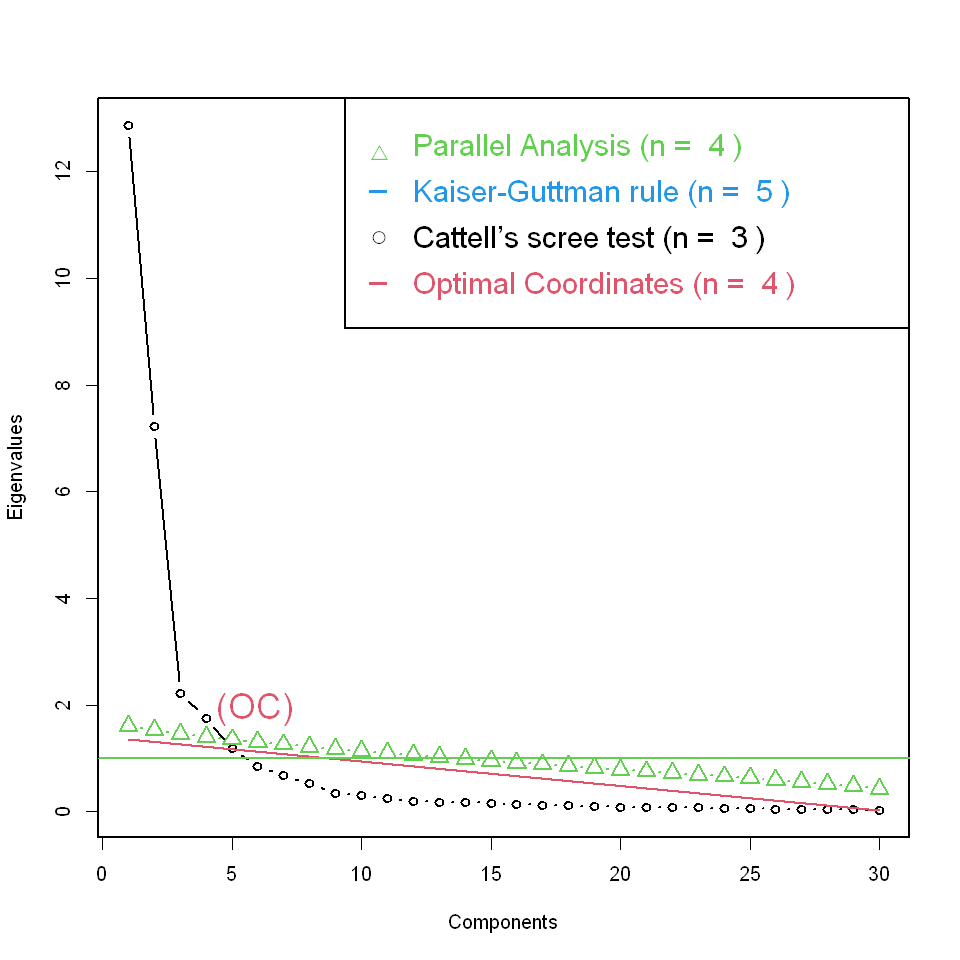

In [13]:
# import relationship dimension ratings scaled from the Data cleaning's output
dim_rel_scaled = read.csv('output_data/cleaning_results/CHN/CHN_dim_rel_scaled_NLP_258r_30d.csv', 
                          row.names=1,encoding='UTF-8',check.names=FALSE)

options(repr.plot.width=8, repr.plot.height=8)
# Parallel analysis, Optimal Coordinates, and  Cattell's Scree Test
ev <- eigen(cor(dim_rel_scaled)) # get eigenvalues
ap <- parallel(subject=nrow(dim_rel_scaled),var=ncol(dim_rel_scaled),model="components",rep=5000,cent=.05) 
nS <- nScree(x=ev$values, aparallel=ap$eigen$qevpea) # "qevpea" indicate 95 centile given cent=.05

plotnScree(nS,elbow = 3, legend=TRUE, main = NULL)
abline(h = 1, col=3, lty=1,lwd =1.8) # Kaiser-Guttman Rule


Loadings:
                           [,1]   [,2]   [,3]   [,4]   [,5]  
Valence.Evaluation         -0.534  0.194         0.790       
Equality                          -0.277 -0.254  0.197  0.786
Activity.Intensity         -0.884 -0.270 -0.128  0.136       
Socioemotional             -0.390 -0.556 -0.623  0.304       
Formality.and.Regulation           0.477  0.803 -0.157       
Intimacy                   -0.770 -0.281 -0.315  0.428       
Visibility                 -0.113         0.777  0.382       
Communal.Sharing           -0.590 -0.603 -0.142  0.450       
Expected.Reciprocity       -0.311  0.684  0.212  0.277  0.318
Strategic                   0.380  0.584  0.340 -0.526       
Concreteness                       0.799               -0.125
Uniqueness                 -0.617 -0.437 -0.513        -0.155
Love.Expression            -0.596 -0.446 -0.323  0.515       
Information.Exchange       -0.793  0.112  0.254  0.355  0.126
Money.Exchange              0.199  0.923        -0.114     

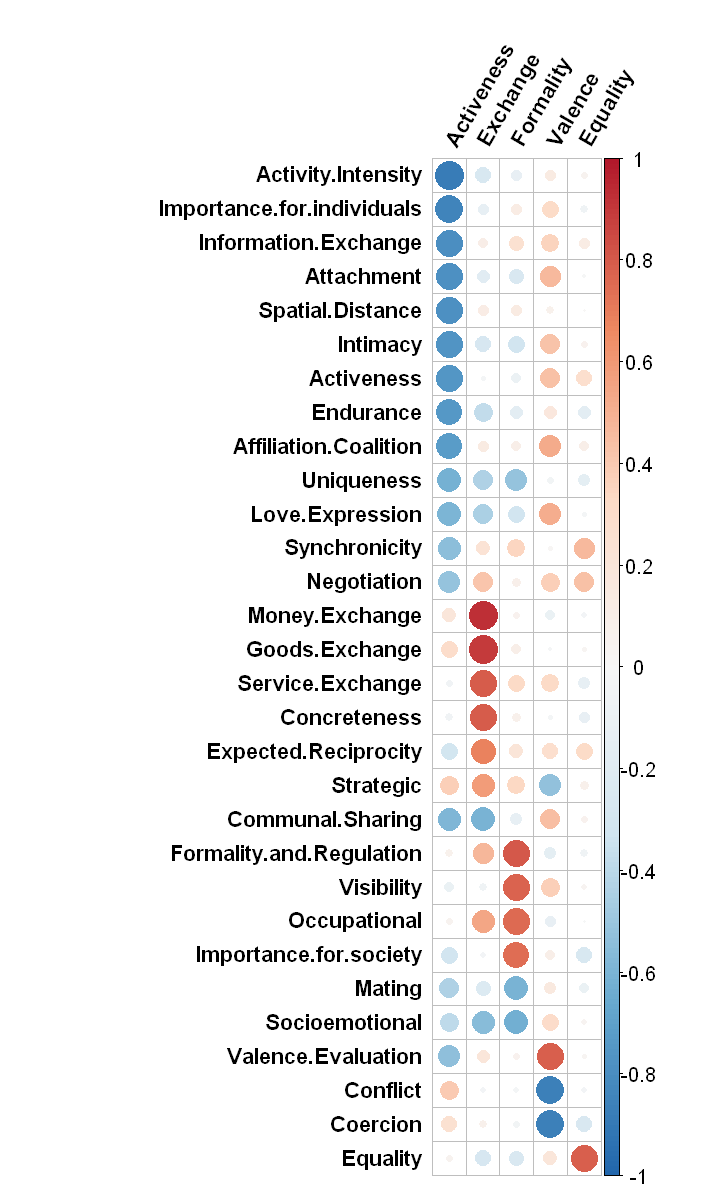

In [15]:
dim_rel_scaled = read.csv('output_data/cleaning_results/CHN/CHN_dim_rel_scaled_NLP_258r_30d.csv',
                          row.names=1,encoding='UTF-8')
# rownames(dim_rel_scaled) <- fix_label(rownames(dim_rel_scaled))

dim_rel.pca = prcomp(dim_rel_scaled)
ncomp = 5

loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

loadings_var = varimax(loadings_none)$loadings
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat
loadings_var

write.csv(loadings_var,'output_data/pca_results/CHN/CHN_NLP_258rel_30d_loadings_var.csv')
write.csv(scores_var,'output_data/pca_results/CHN/CHN_NLP_258rel_30d_scores_var.csv')

loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])
colnames(loadings_var_reorder) = c('Activeness','Exchange','Formality','Valence','Equality')

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:30)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:5)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(Activeness)
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(Exchange))
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(desc(Formality))
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(desc(Valence))
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(desc(Equality))

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5)
loadings_var_reorder = loadings_var_reorder[1:5]

options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1,1),cl.ratio = 0.4,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))